---------------------------------------
# Introduction

**Neural Style Transfer**

> Neural Style Transfer (NST) refers to a class of software algorithms that manipulate digital images, or videos, in order to adopt the appearance or visual style of another image. NST algorithms are characterized by their use of deep neural networks for the sake of image transformation. Common uses for NST are the creation of artificial artwork from photographs, for example by transferring the appearance of famous paintings to user-supplied photographs. Several notable mobile apps use NST techniques for this purpose, including DeepArt and Prisma. This method has been used by artists and designers around the globe to develop new artwork based on existent style(s).



Style transfer means that when a content image and a style image are given, the outline and shape of the image are similar to the content image, and the color or texture is changed to be similar to the style image.

By separating content and style, you can mix content and style of different images.


A pre-trained VGG19 Net is used as a model to extract content and style. It then uses the losses of the content and style to iteratively update the target image until the desired result is achieved.

In [114]:
# import resources
%matplotlib inline

from PIL import Image
from io import BytesIO
import matplotlib.pyplot as plt
import numpy as np

import torch
import torch.optim as optim
import requests
from torchvision import transforms, models

------------------------------------------------
# 1. Load in model

VGG19 is divided into two parts.

* vgg19.features: All convolutional layers and pooling layers
* vgg19.classifier: The last three linear layers are the classifier layer.



In [115]:
# get the "features" portion of VGG19 (we will not need the "classifier" portion)
vgg = models.vgg19(pretrained=True).features

# freeze all VGG parameters since we're only optimizing the target image
for param in vgg.parameters():
    param.requires_grad_(False)

In [116]:
# move the model to GPU, if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

vgg.to(device)

Sequential(
  (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): ReLU(inplace=True)
  (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (3): ReLU(inplace=True)
  (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (6): ReLU(inplace=True)
  (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (8): ReLU(inplace=True)
  (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (11): ReLU(inplace=True)
  (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (13): ReLU(inplace=True)
  (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (15): ReLU(inplace=True)
  (16): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (17): ReLU(inplace=True)
  (18): MaxPoo

-----------------------------------------------
# 2. Load in Content and Style Images

Load the content image and style image to be used for style transfer. The load_image function transforms the image and loads it in the form of normalized Tensors.



In [117]:
def load_image(img_path, max_size=128, shape=None):
    ''' Load in and transform an image, making sure the image
       is <= 400 pixels in the x-y dims.'''
    if "http" in img_path:
        response = requests.get(img_path)
        image = Image.open(BytesIO(response.content)).convert('RGB')
    else:
        image = Image.open(img_path).convert('RGB')
    
    # large images will slow down processing
    if max(image.size) > max_size:
        size = max_size
    else:
        size = max(image.size)
    
    if shape is not None:
        size = shape
        
    in_transform = transforms.Compose([
                        transforms.Resize(size),
                        transforms.ToTensor(),
                        transforms.Normalize((0.485, 0.456, 0.406), 
                                             (0.229, 0.224, 0.225))])

    # discard the transparent, alpha channel (that's the :3) and add the batch dimension
    image = in_transform(image)[:3,:,:].unsqueeze(0)
    
    return image

Load the content image and style image.

In [118]:
# load in content and style image
content = load_image('/content/drive/MyDrive/Neural style transfer/NST/Data/TestCases/22714.jpg').to(device)
# Resize style to match content, makes code easier
style = load_image('/content/drive/MyDrive/Neural style transfer/NST/Data2/Style Images/starry_night.jpg').to(device)

In [119]:
# helper function for un-normalizing an image 
# and converting it from a Tensor image to a NumPy image for display
def im_convert(tensor):
    """ Display a tensor as an image. """
    
    image = tensor.to("cpu").clone().detach()
    image = image.numpy().squeeze()
    image = image.transpose(1,2,0)
    image = image * np.array((0.229, 0.224, 0.225)) + np.array((0.485, 0.456, 0.406))
    image = image.clip(0, 1)

    return image

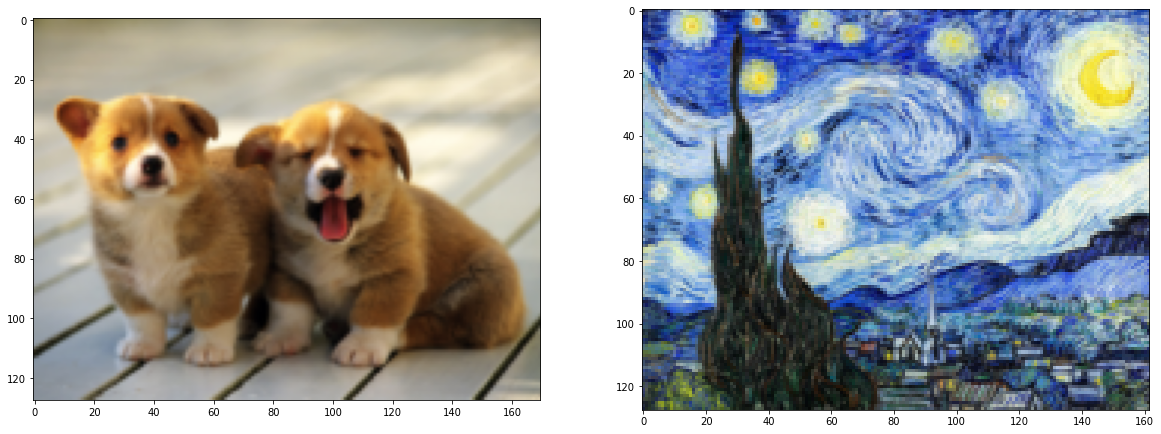

In [120]:
# display the images
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 10))
# content and style ims side-by-side
ax1.imshow(im_convert(content))
ax2.imshow(im_convert(style))

In [121]:
def get_features(image, model, layers=None):
    """ Run an image forward through a model and get the features for 
        a set of layers. Default layers are for VGGNet matching Gatys et al (2016)
    """
    
    if layers is None:
        layers = {'0': 'conv1_1',
                  '5': 'conv2_1', 
                  '10': 'conv3_1', 
                  '19': 'conv4_1',
                  '21': 'conv4_2',  ## content representation
                  '28': 'conv5_1'}
        
    features = {}
    x = image
    # model._modules is a dictionary holding each module in the model
    for name, layer in model._modules.items():
        x = layer(x)
        if name in layers:
            features[layers[name]] = x
            
    return features

--------------------------------------------------
# 3. Gram Matrix

![](https://miro.medium.com/max/1400/1*VAQs1KSfbysnloPah_fHGQ.gif)




> The matrix expressing the correlation of this Channel is called Gram Matrix. Loss is minimized by defining the difference between this Gram Matrix and the Gram Matrix of the newly created image as a Loss Function. Next, in order to reflect the content, the loss function is calculated in units of pixels from the feature map spit out from each pre-trained CNN. In this way, a new image is created that minimizes the Loss calculated from Style and Loss calculated from Content. 




In [122]:
def gram_matrix(tensor):
    """ Calculate the Gram Matrix of a given tensor         
    """
    
    # get the batch_size, depth, height, and width of the Tensor
    _, d, h, w = tensor.size()
    
    # reshape so we're multiplying the features for each channel
    tensor = tensor.view(d, h * w)
    
    # calculate the gram matrix
    gram = torch.mm(tensor, tensor.t())
    
    return gram 

The function that extracts the features of a given convolutional layer and computes the Gram Matrix is made. Putting it all together, we extract the features from the image and compute the Gram Matrix for each layer from the style representation.

In [123]:
# get content and style features only once before training
content_features = get_features(content, vgg)
style_features = get_features(style, vgg)

# calculate the gram matrices for each layer of our style representation
style_grams = {layer: gram_matrix(style_features[layer]) for layer in style_features}

# create a third "target" image and prep it for change
# it is a good idea to start off with the target as a copy of our *content* image
# then iteratively change its style
target = content.clone().requires_grad_(True).to(device)

---------------------------------------------
# 4. Define Losses and Weights

**Individual Layer Style Weights**

You can give the option to weight the style expression in each relevant layer. It is recommended that the layer weight range from 0 to 1. By giving more weight to conv1_1 and conv2_1, more style artifacts can be reflected in the final target image.

**Content and Style Weight**

Define alpha (content_weight) and beta (style_weight). This ratio affects the style of the final image. It is recommended to leave content_weight = 1 and set style_weight to achieve the desired ratio.

In [124]:
# weights for each style layer 
# weighting earlier layers more will result in *larger* style artifacts
# notice we are excluding `conv4_2` our content representation
style_weights = {'conv1_1': 1,
                 'conv2_1': 0.75,
                 'conv3_1': 0.2,
                 'conv4_1': 0.2,
                 'conv5_1': 0.2}

content_weight = 1  # alpha
style_weight = 1e3  # beta

# 5. Update Target and Calculate Losses

**Content Loss**

The content loss is calculated as the MSE between the target and the content feature in the 'conv4_2' layer.

**Style Loss**

The style loss is the loss between the target image and the style image. That is, it refers to the difference between the gram matrix of the style image and the gram matrix of the target image. Loss is calculated using MSE

**Total Loss**

Finally, the total loss is calculated by summing the style and content losses and weighting them with the specified alpha and beta.

Total loss:  7321.68017578125


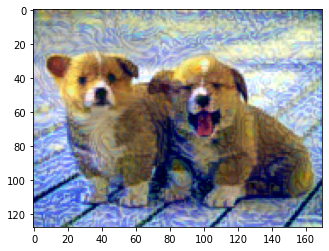

Total loss:  1187.216796875


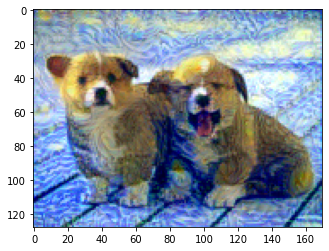

Total loss:  803.3447875976562


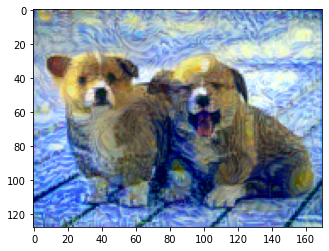

Total loss:  622.1321411132812


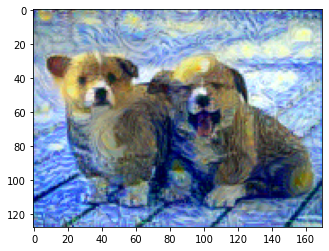

Total loss:  513.5419921875


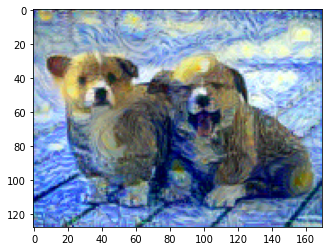

Total loss:  442.6982116699219


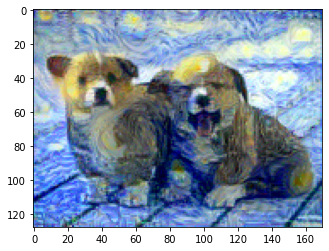

Total loss:  393.90460205078125


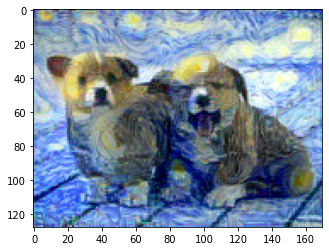

Total loss:  357.5713806152344


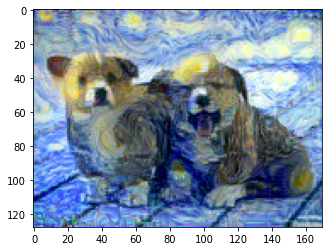

Total loss:  328.9842529296875


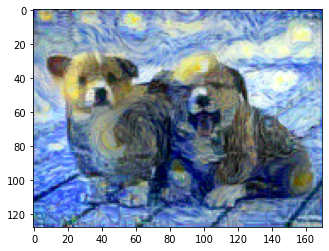

Total loss:  305.5948791503906


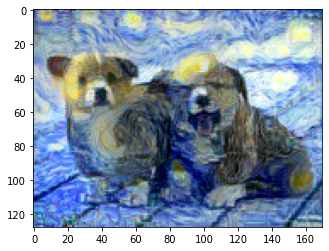

In [125]:
# for displaying the target image, intermittently
show_every = 500

# iteration hyperparameters
optimizer = optim.Adam([target], lr=0.003)
steps = 5001  # decide how many iterations to update your image (5000)

for ii in range(1, steps+1):
    
    # get the features from your target image
    target_features = get_features(target, vgg)
    
    # the content loss
    content_loss = torch.mean((target_features['conv4_2'] - content_features['conv4_2'])**2)
    
    # the style loss
    # initialize the style loss to 0
    style_loss = 0
    # then add to it for each layer's gram matrix loss
    for layer in style_weights:
        # get the "target" style representation for the layer
        target_feature = target_features[layer]
        target_gram = gram_matrix(target_feature)
        _, d, h, w = target_feature.shape
        # get the "style" style representation
        style_gram = style_grams[layer]
        # the style loss for one layer, weighted appropriately
        layer_style_loss = style_weights[layer] * torch.mean((target_gram - style_gram)**2)
        # add to the style loss
        style_loss += layer_style_loss / (d * h * w)
        
    # calculate the *total* loss
    total_loss = content_weight * content_loss + style_weight * style_loss
    
    # update your target image
    optimizer.zero_grad()
    total_loss.backward()
    optimizer.step()
    
    # display intermediate images and print the loss
    if  ii % show_every == 0:
        print('Total loss: ', total_loss.item())
        plt.imshow(im_convert(target))
        plt.show()

-----------------------------------------------------------------
# 6. Check the last result

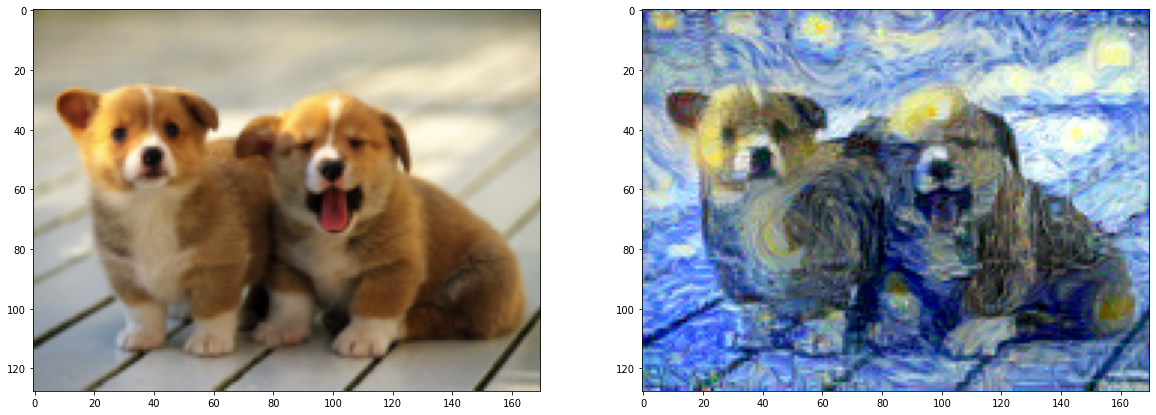

In [126]:
# display content and final, target image
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 10))
ax1.imshow(im_convert(content))
ax2.imshow(im_convert(target))

### Limitations and Potential Improvements:

1. **Style Transfer Quality:**
   - *Limitation:* The quality of style transfer heavily depends on the chosen hyperparameters, including content weights, style weights, and learning rates. Finding the right balance can be challenging.
   - *Improvement:* Consider experimenting with different hyperparameter values or exploring advanced optimization techniques to achieve better style transfer quality.

2. **Computational Cost:**
   - *Limitation:* Neural style transfer, especially using deep neural networks, can be computationally expensive and time-consuming.
   - *Improvement:* Explore methods for model optimization, such as model quantization or using smaller neural architectures, to reduce the computational cost while maintaining performance.

3. **Artifacts and Overfitting:**
   - *Limitation:* The model may generate artifacts or overfit to specific patterns in the style image, leading to unnatural results.
   - *Improvement:* Regularization techniques, such as total variation regularization, can be employed to mitigate overfitting and improve the generalization of the model.

4. **Limited Content Preservation:**
   - *Limitation:* While the model aims to preserve content, there might be instances where the content is not faithfully retained.
   - *Improvement:* Experiment with different content and style weight ratios to enhance content preservation, and consider incorporating perceptual loss functions for better content representation.

5. **Lack of Diversity:**
   - *Limitation:* The model may struggle to handle diverse styles or images with complex structures.
   - *Improvement:* Training the model on a diverse dataset or incorporating domain-specific techniques may help generalize the style transfer across a broader range of images.
